## Image Resolution

### Check S2 image resolution

In [6]:
import rasterio

s2_path = "../data/raw/images/S2H_2023_2023_05_01_nodata.tif"

with rasterio.open(s2_path) as src:
    print("CRS:", src.crs)
    print("Transform:", src.transform)
    print("Total bands:", src.count)
    print("Overall shape (height, width):", (src.height, src.width))
    print()

    # Check resolution (pixel size)
    res = src.res
    print("Nominal resolution (per transform):", res)

    # Check each band
    for i in range(1, src.count + 1):
        dtype = src.dtypes[i-1]
        nodata = src.nodatavals[i-1]
        print(f"Band {i}: dtype={dtype}, nodata={nodata}")

CRS: EPSG:4326
Transform: | 0.00, 0.00,-122.08|
| 0.00,-0.00, 39.18|
| 0.00, 0.00, 1.00|
Total bands: 9
Overall shape (height, width): (5495, 7217)

Nominal resolution (per transform): (8.983152847443538e-05, 8.983152848043673e-05)
Band 1: dtype=float64, nodata=-9999.0
Band 2: dtype=float64, nodata=-9999.0
Band 3: dtype=float64, nodata=-9999.0
Band 4: dtype=float64, nodata=-9999.0
Band 5: dtype=float64, nodata=-9999.0
Band 6: dtype=float64, nodata=-9999.0
Band 7: dtype=float64, nodata=-9999.0
Band 8: dtype=float64, nodata=-9999.0
Band 9: dtype=float64, nodata=-9999.0


### Check CDL resolution

In [23]:
cdl_path = "../data/raw/cdl/2023_30m_cdls_clipped_reprojected_filtered.tif"

with rasterio.open(cdl_path) as src:
    print("CDL CRS:", src.crs)
    print("Transform:", src.transform)
    print("Shape (height, width):", (src.height, src.width))
    print("Resolution:", src.res)
    print("Bounds:", src.bounds)
    print("Data type:", src.dtypes[0])
    print("NoData:", src.nodata)

CDL CRS: EPSG:4326
Transform: | 0.00, 0.00,-122.24|
| 0.00,-0.00, 39.30|
| 0.00, 0.00, 1.00|
Shape (height, width): (2262, 2958)
Resolution: (0.0003315043948613902, 0.00033150309460654523)
Bounds: BoundingBox(left=-122.24389, bottom=38.55495, right=-121.2633, top=39.30481)
Data type: float32
NoData: -3.4028234663852886e+38


### Change CDL resolution to match S2

In [24]:
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np

# Paths
s2_ref = "../data/raw/images/S2H_2023_2023_05_01_nodata.tif"   # your 9-band Sentinel-2 stack
in_cdl_30m = "../data/raw/cdl/2023_30m_cdls_clipped_reprojected_filtered.tif"
out_cdl_10m = "../data/raw/cdl/2023_30m_cdls_10m.tif"

with rasterio.open(s2_ref) as ref, rasterio.open(in_cdl_30m) as src:
    # Prepare output array matching Sentinel-2 shape
    aligned = np.empty((ref.height, ref.width), dtype=src.dtypes[0])

    reproject(
        source=src.read(1),
        destination=aligned,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=ref.transform,
        dst_crs=ref.crs,
        dst_width=ref.width,
        dst_height=ref.height,
        resampling=Resampling.nearest  # preserve class IDs
    )

    # Copy reference profile
    profile = ref.profile.copy()
    profile.update(
        dtype=src.dtypes[0],
        count=1,
        nodata=src.nodata if src.nodata is not None else 0
    )

    # Save resampled CDL
    with rasterio.open(out_cdl_10m, "w", **profile) as dst:
        dst.write(aligned, 1)

print("CDL resampled to 10m grid:", out_cdl_10m)

CDL resampled to 10m grid: ../data/raw/cdl/2023_30m_cdls_10m.tif


### Check CDL class labels

In [25]:
with rasterio.open("../data/raw/cdl/2023_30m_cdls_10m.tif") as src:
    arr = src.read(1)
    print("Unique values in label mask:", np.unique(arr))
    for val in np.unique(arr):
        if val == src.nodata:
            continue
        count = np.sum(arr == val)
        print(f"Class {val}: {count} pixels")

Unique values in label mask: [  0.   1.   3.  24.  36.  54.  69.  75.  76. 210. 211.]
Class 0.0: 16710242 pixels
Class 1.0: 912031 pixels
Class 3.0: 9210173 pixels
Class 24.0: 1267241 pixels
Class 36.0: 597726 pixels
Class 54.0: 2168552 pixels
Class 69.0: 727411 pixels
Class 75.0: 4393388 pixels
Class 76.0: 2804998 pixels
Class 210.0: 652877 pixels
Class 211.0: 212776 pixels
Class 54.0: 2168552 pixels
Class 69.0: 727411 pixels
Class 75.0: 4393388 pixels
Class 76.0: 2804998 pixels
Class 210.0: 652877 pixels
Class 211.0: 212776 pixels


### CDL remap

In [26]:
# CDL codes present
cdl_classes = [0, 1, 3, 24, 36, 54, 69, 75, 76, 210, 211]

# Map them into compact range
mapping = {
    0: 0,   # Background
    1: 1,   # Corn
    3: 2,   # Rice
    24: 3,  # Winter Wheat
    36: 4,  # Alfalfa
    54: 5,  # Tomatoes
    69: 6,  # Grapes
    75: 7,  # Almonds
    76: 8,  # Walnuts
    210: 9, # Prunes
    211: 10 # Olives
}

# Define a new nodata value suitable for uint8, e.g., 0 or 255
# Since 0 is used for "Background", let's use 255.
new_nodata = 255

def remap_mask(mask, src_nodata):
    # Create a copy to avoid modifying the original mask
    remapped_mask = np.full(mask.shape, new_nodata, dtype=np.uint8)
    for old_val, new_val in mapping.items():
        remapped_mask[mask == old_val] = new_val
    return remapped_mask

# Example: remap one mask
mask_path = "../data/raw/cdl/2023_30m_cdls_10m.tif"
out_path = "../data/raw/cdl/2023_30m_cdls_10m_remap.tif"

with rasterio.open(mask_path) as src:
    mask = src.read(1)
    profile = src.profile
    
    # Remap the data
    remapped = remap_mask(mask, src.nodata)

    # Update the profile for the output file
    profile.update(
        dtype=rasterio.uint8,
        nodata=new_nodata,
        compress='lzw'  # Optional: good compression for integer rasters
    )

    with rasterio.open(out_path, "w", **profile) as dst:
        dst.write(remapped, 1)

print("Unique values after remap:", np.unique(remapped))

Unique values after remap: [ 0  1  2  3  4  5  6  7  8  9 10]


## Visualization

### NDVI map

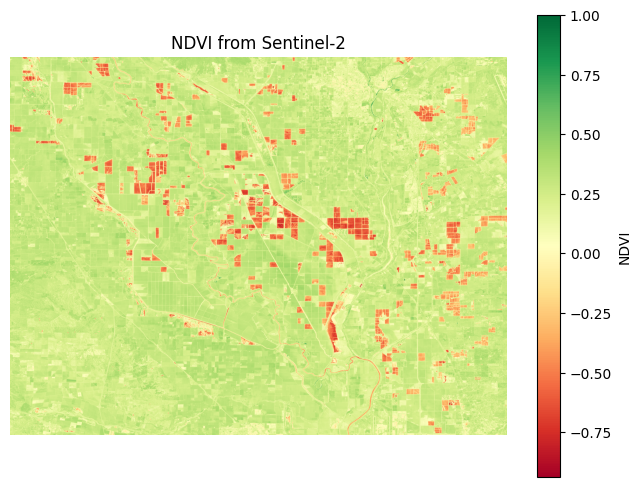

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Path to Sentinel-2 image (multi-band GeoTIFF)
s2_path = "../data/raw/images/S2H_2023_2023_05_01_nodata.tif"

# Open dataset
with rasterio.open(s2_path) as src:
    # Band indices may differ depending on your file order
    red = src.read(4).astype("float32")   # Band 4 = Red
    nir = src.read(8).astype("float32")   # Band 8 = NIR
    profile = src.profile

# Avoid divide-by-zero
ndvi = (nir - red) / (nir + red + 1e-9)

# Show NDVI
plt.figure(figsize=(8,6))
plt.imshow(ndvi, cmap="RdYlGn")
plt.colorbar(label="NDVI")
plt.title("NDVI from Sentinel-2")
plt.axis("off")
plt.show()

### Single image NDVI

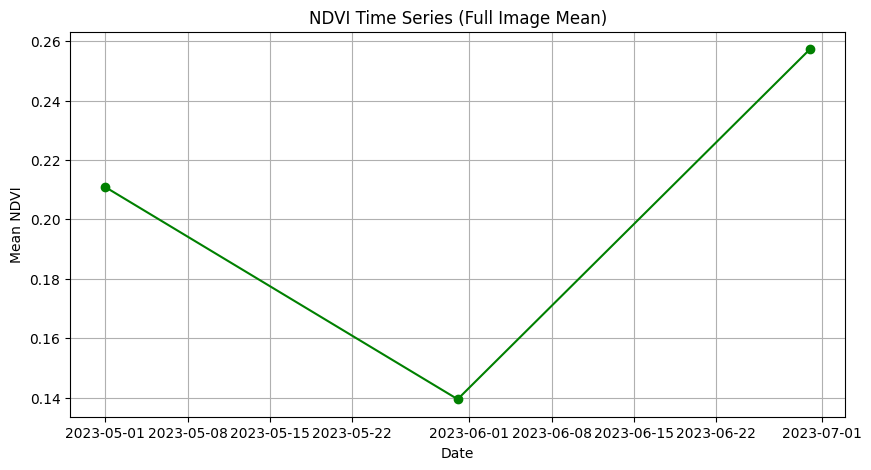

In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import glob
import os
from datetime import datetime

image_folder = "../data/raw/images"

image_files = sorted(glob.glob(os.path.join(image_folder, "*.tif")))

ndvi_series = []

for img in image_files:
    with rasterio.open(img) as src:
        red = src.read(4).astype("float32")  # Band 4 = Red
        nir = src.read(8).astype("float32")  # Band 8 = NIR

        ndvi = (nir - red) / (nir + red + 1e-9)
        mean_ndvi = float(np.nanmean(ndvi))
        # filename: S2H_2023_2023_05_01_nodata.tif
        parts = os.path.basename(img).split('_')
        date = datetime.strptime("_".join(parts[2:5]), "%Y_%m_%d")

        ndvi_series.append((date, mean_ndvi))

# sort by date
ndvi_series.sort(key=lambda x: x[0])
dates, values = zip(*ndvi_series)

# plot NDVI time series
plt.figure(figsize=(10,5))
plt.plot(dates, values, marker="o", color="green")
plt.title("NDVI Time Series (Full Image Mean)")
plt.xlabel("Date")
plt.ylabel("Mean NDVI")
plt.grid(True)
plt.show()

### Multiple images NDVI by class

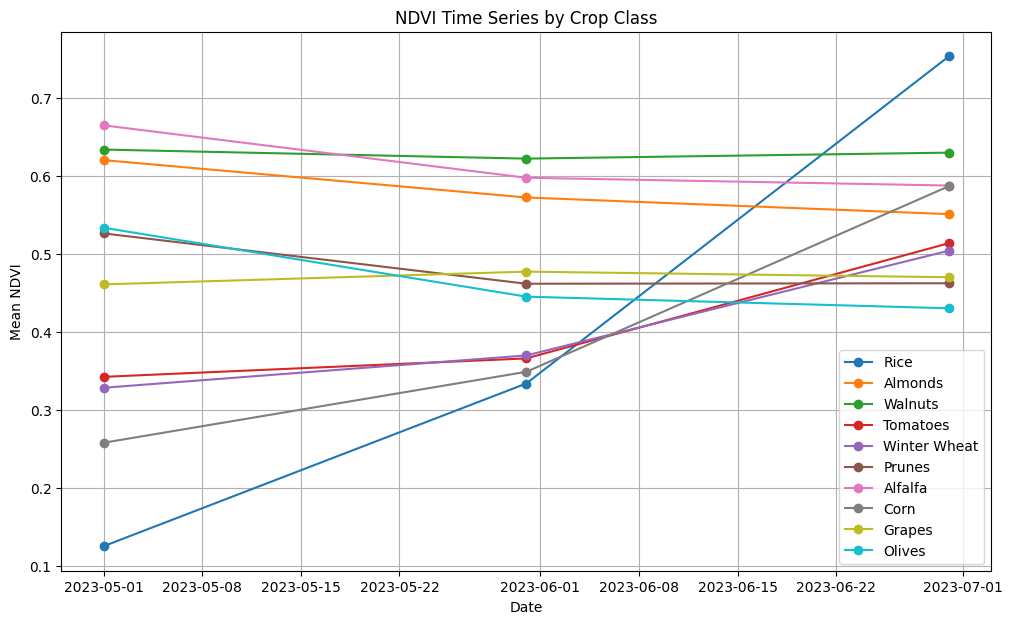

In [13]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from datetime import datetime

# Paths
image_folder = "../data/raw/images"   # Sentinel-2 time series
cdl_path = "../data/raw/cdl/2024_30m_cdls_10m.tif"  # CDL raster

# Classes of interest (your top 10 crops)
class_map = {
    3: "Rice",
    75: "Almonds",
    76: "Walnuts",
    54: "Tomatoes",
    24: "Winter Wheat",
    210: "Prunes",
    36: "Alfalfa",
    1: "Corn",
    69: "Grapes",
    211: "Olives",
}

# Load CDL once
with rasterio.open(cdl_path) as src:
    labels = src.read(1)
    cdl_profile = src.profile

# Collect Sentinel-2 images
image_files = sorted(glob.glob(os.path.join(image_folder, "*.tif")))

# Dictionary to store results {class_id: [(date, mean_ndvi), ...]}
ndvi_per_class = {cid: [] for cid in class_map.keys()}

for img in image_files:
    with rasterio.open(img) as src:
        # Ensure same resolution/extent as CDL
        assert src.shape == labels.shape, "Image and CDL must be aligned!"

        # Read Red + NIR
        red = src.read(3).astype("float32")
        nir = src.read(7).astype("float32")

        # Compute NDVI
        ndvi = (nir - red) / (nir + red + 1e-9)

        # Extract date from filename, e.g., S2H_2023_2023_05_01_nodata.tif
        parts = os.path.basename(img).split('_')
        date_str = "_".join(parts[2:5])
        try:
            date = datetime.strptime(date_str, "%Y_%m_%d")
        except ValueError:
            print(f"Warning: Could not parse date from filename: {os.path.basename(img)}")
            date = None

        # Compute NDVI per class
        for cid, cname in class_map.items():
            mask = labels == cid
            if np.any(mask):
                mean_ndvi = float(np.nanmean(ndvi[mask]))
                ndvi_per_class[cid].append((date, mean_ndvi))

# Plot
plt.figure(figsize=(12,7))
for cid, cname in class_map.items():
    series = sorted(ndvi_per_class[cid], key=lambda x: x[0])
    if series:  # skip empty classes
        dates, values = zip(*series)
        plt.plot(dates, values, marker="o", label=cname)

plt.title("NDVI Time Series by Crop Class")
plt.xlabel("Date")
plt.ylabel("Mean NDVI")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
import glob, rasterio, numpy as np

mask_dir = "../data/processed/crop_mapping_multi_images_subset/masks"
unique_vals = set()

for f in glob.glob(mask_dir + "/*.tif"):
    with rasterio.open(f) as src:
        unique_vals |= set(np.unique(src.read(1)))

print("Unique values across dataset:", sorted(unique_vals))

Unique values across dataset: [np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9), np.uint8(10)]
